In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

2023-05-18 21:06:52.218456: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 21:06:52.634141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 21:06:52.634157: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-18 21:06:54.057752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"training_data.csv")

In [3]:
bd = pd.read_csv(r"training_data.csv")

def tratar_dados(bd):
    bd = ordernar(bd)
    bd = RoadsCleaner(bd)
    #bd = data(bd)
    bd = valores_em_falta(bd)
    bd = eliminar(bd)
    bd = incidentsNumbers(bd)
    bd = luminosidade(bd)
    bd = rainNumbers(bd)
    bd = delayNumbers(bd)
    bd = removeOutlier(bd)
    indice_treino, indice_val=split_data(bd, perc=10)
    escala, bd = data_normalization(bd, norm_range=(-1, 1))
    return bd,indice_treino,indice_val,escala

bd,indice_treino,indice_val,escala=tratar_dados(bd)

/home/sendnuggets/Desktop/Mestrado_MMC/Classificadores e Sistemas Conexionistas/CSC/datacleaner.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd['magnitude_of_delay'][i] = None
/home/sendnuggets/Desktop/Mestrado_MMC/Classificadores e Sistemas Conexionistas/CSC/datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor
/home/sendnuggets/Desktop/Mestrado_MMC/Classificadores e Sistemas Conexionistas/CSC/datacleaner.py:115: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain t

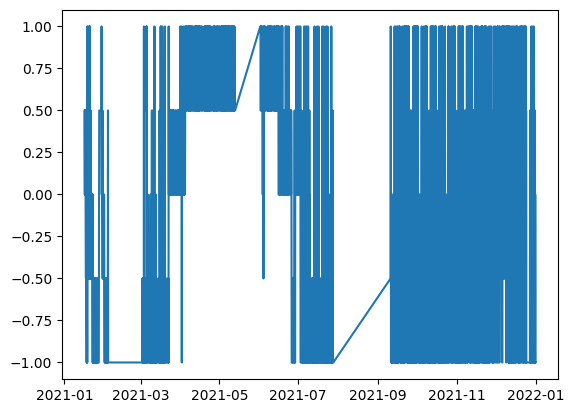

In [4]:
bd.index = pd.to_datetime(bd["record_date"], format="%Y-%m-%d %H:%M:00")
serie(bd,"incidents")
newBd = bd[["incidents","record_date"]]

<Axes: xlabel='record_date'>

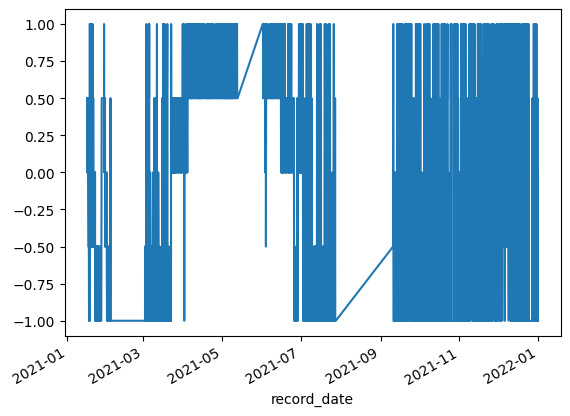

In [6]:
train, test = newBd[0:-600], newBd[-600:]
temp = bd["incidents"]
temp.plot()

In [7]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((4995, 5, 1), (4995,))

In [9]:
X_train1, y_train1 = X1[:4400], y1[:4400]
X_val1, y_val1 = X1[4400:4800], y1[4400:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4400, 5, 1), (4400,), (400, 5, 1), (400,), (195, 5, 1), (195,))

Construção do modelo com uma LSTM

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-05-17 16:28:56.797163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-17 16:28:56.797233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sendnuggets-VivoBook-ASUSLaptop-X412FL-X412FL): /proc/driver/nvidia/version does not exist
2023-05-17 16:28:56.805769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [11]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [12]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
133/138 [===========================>..] - ETA: 0s - loss: 0.4747 - root_mean_squared_error: 0.6890

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 6s 31ms/step - loss: 0.4705 - root_mean_squared_error: 0.6859 - val_loss: 0.5185 - val_root_mean_squared_error: 0.7201
Epoch 2/100
131/138 [===========================>..] - ETA: 0s - loss: 0.3021 - root_mean_squared_error: 0.5497

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 24ms/step - loss: 0.3013 - root_mean_squared_error: 0.5489 - val_loss: 0.5009 - val_root_mean_squared_error: 0.7078
Epoch 3/100
138/138 [==============================] - 0s 3ms/step - loss: 0.2544 - root_mean_squared_error: 0.5044 - val_loss: 0.5134 - val_root_mean_squared_error: 0.7165
Epoch 4/100
138/138 [==============================] - 0s 3ms/step - loss: 0.2468 - root_mean_squared_error: 0.4968 - val_loss: 0.5039 - val_root_mean_squared_error: 0.7099
Epoch 5/100
133/138 [===========================>..] - ETA: 0s - loss: 0.2416 - root_mean_squared_error: 0.4915

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.2413 - root_mean_squared_error: 0.4912 - val_loss: 0.4951 - val_root_mean_squared_error: 0.7036
Epoch 6/100
125/138 [==========================>...] - ETA: 0s - loss: 0.2331 - root_mean_squared_error: 0.4828

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857 - val_loss: 0.4840 - val_root_mean_squared_error: 0.6957
Epoch 7/100
130/138 [===========================>..] - ETA: 0s - loss: 0.2329 - root_mean_squared_error: 0.4826

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803 - val_loss: 0.4701 - val_root_mean_squared_error: 0.6856
Epoch 8/100
124/138 [=========================>....] - ETA: 0s - loss: 0.2183 - root_mean_squared_error: 0.4673

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752 - val_loss: 0.4573 - val_root_mean_squared_error: 0.6762
Epoch 9/100
132/138 [===========================>..] - ETA: 0s - loss: 0.2217 - root_mean_squared_error: 0.4708

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.2206 - root_mean_squared_error: 0.4697 - val_loss: 0.4464 - val_root_mean_squared_error: 0.6681
Epoch 10/100
129/138 [===========================>..] - ETA: 0s - loss: 0.2172 - root_mean_squared_error: 0.4660

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641 - val_loss: 0.4319 - val_root_mean_squared_error: 0.6572
Epoch 11/100
133/138 [===========================>..] - ETA: 0s - loss: 0.2091 - root_mean_squared_error: 0.4572

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587 - val_loss: 0.4122 - val_root_mean_squared_error: 0.6420
Epoch 12/100
132/138 [===========================>..] - ETA: 0s - loss: 0.2027 - root_mean_squared_error: 0.4503

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540 - val_loss: 0.4046 - val_root_mean_squared_error: 0.6361
Epoch 13/100
131/138 [===========================>..] - ETA: 0s - loss: 0.2015 - root_mean_squared_error: 0.4489

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 27ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501 - val_loss: 0.3923 - val_root_mean_squared_error: 0.6263
Epoch 14/100
125/138 [==========================>...] - ETA: 0s - loss: 0.1983 - root_mean_squared_error: 0.4453

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461 - val_loss: 0.3763 - val_root_mean_squared_error: 0.6134
Epoch 15/100
134/138 [============================>.] - ETA: 0s - loss: 0.1953 - root_mean_squared_error: 0.4419

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.1957 - root_mean_squared_error: 0.4423 - val_loss: 0.3689 - val_root_mean_squared_error: 0.6074
Epoch 16/100
132/138 [===========================>..] - ETA: 0s - loss: 0.1951 - root_mean_squared_error: 0.4417

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1932 - root_mean_squared_error: 0.4395 - val_loss: 0.3623 - val_root_mean_squared_error: 0.6019
Epoch 17/100
127/138 [==========================>...] - ETA: 0s - loss: 0.1913 - root_mean_squared_error: 0.4374

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.1909 - root_mean_squared_error: 0.4369 - val_loss: 0.3592 - val_root_mean_squared_error: 0.5993
Epoch 18/100
124/138 [=========================>....] - ETA: 0s - loss: 0.1894 - root_mean_squared_error: 0.4352

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1889 - root_mean_squared_error: 0.4346 - val_loss: 0.3518 - val_root_mean_squared_error: 0.5931
Epoch 19/100
125/138 [==========================>...] - ETA: 0s - loss: 0.1864 - root_mean_squared_error: 0.4317

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.1873 - root_mean_squared_error: 0.4327 - val_loss: 0.3472 - val_root_mean_squared_error: 0.5893
Epoch 20/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1852 - root_mean_squared_error: 0.4304 - val_loss: 0.3473 - val_root_mean_squared_error: 0.5893
Epoch 21/100
136/138 [============================>.] - ETA: 0s - loss: 0.1824 - root_mean_squared_error: 0.4271

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1842 - root_mean_squared_error: 0.4292 - val_loss: 0.3420 - val_root_mean_squared_error: 0.5848
Epoch 22/100
125/138 [==========================>...] - ETA: 0s - loss: 0.1822 - root_mean_squared_error: 0.4268

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.1822 - root_mean_squared_error: 0.4269 - val_loss: 0.3396 - val_root_mean_squared_error: 0.5827
Epoch 23/100
127/138 [==========================>...] - ETA: 0s - loss: 0.1785 - root_mean_squared_error: 0.4225

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1806 - root_mean_squared_error: 0.4249 - val_loss: 0.3350 - val_root_mean_squared_error: 0.5788
Epoch 24/100
127/138 [==========================>...] - ETA: 0s - loss: 0.1808 - root_mean_squared_error: 0.4252

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 23ms/step - loss: 0.1794 - root_mean_squared_error: 0.4236 - val_loss: 0.3309 - val_root_mean_squared_error: 0.5753
Epoch 25/100
126/138 [==========================>...] - ETA: 0s - loss: 0.1782 - root_mean_squared_error: 0.4221

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1781 - root_mean_squared_error: 0.4221 - val_loss: 0.3297 - val_root_mean_squared_error: 0.5742
Epoch 26/100
134/138 [============================>.] - ETA: 0s - loss: 0.1772 - root_mean_squared_error: 0.4209

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 24ms/step - loss: 0.1773 - root_mean_squared_error: 0.4211 - val_loss: 0.3272 - val_root_mean_squared_error: 0.5720
Epoch 27/100
128/138 [==========================>...] - ETA: 0s - loss: 0.1748 - root_mean_squared_error: 0.4181

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1763 - root_mean_squared_error: 0.4198 - val_loss: 0.3245 - val_root_mean_squared_error: 0.5696
Epoch 28/100
128/138 [==========================>...] - ETA: 0s - loss: 0.1770 - root_mean_squared_error: 0.4207

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1757 - root_mean_squared_error: 0.4191 - val_loss: 0.3219 - val_root_mean_squared_error: 0.5674
Epoch 29/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1751 - root_mean_squared_error: 0.4185 - val_loss: 0.3235 - val_root_mean_squared_error: 0.5687
Epoch 30/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1745 - root_mean_squared_error: 0.4178 - val_loss: 0.3221 - val_root_mean_squared_error: 0.5675
Epoch 31/100
128/138 [==========================>...] - ETA: 0s - loss: 0.1762 - root_mean_squared_error: 0.4197

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1741 - root_mean_squared_error: 0.4172 - val_loss: 0.3207 - val_root_mean_squared_error: 0.5663
Epoch 32/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1735 - root_mean_squared_error: 0.4165 - val_loss: 0.3210 - val_root_mean_squared_error: 0.5666
Epoch 33/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1731 - root_mean_squared_error: 0.4161 - val_loss: 0.3235 - val_root_mean_squared_error: 0.5687
Epoch 34/100
123/138 [=========================>....] - ETA: 0s - loss: 0.1710 - root_mean_squared_error: 0.4135

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 24ms/step - loss: 0.1726 - root_mean_squared_error: 0.4154 - val_loss: 0.3190 - val_root_mean_squared_error: 0.5648
Epoch 35/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1723 - root_mean_squared_error: 0.4151 - val_loss: 0.3191 - val_root_mean_squared_error: 0.5649
Epoch 36/100
131/138 [===========================>..] - ETA: 0s - loss: 0.1732 - root_mean_squared_error: 0.4162

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1724 - root_mean_squared_error: 0.4152 - val_loss: 0.3185 - val_root_mean_squared_error: 0.5644
Epoch 37/100
124/138 [=========================>....] - ETA: 0s - loss: 0.1676 - root_mean_squared_error: 0.4094

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 24ms/step - loss: 0.1718 - root_mean_squared_error: 0.4145 - val_loss: 0.3183 - val_root_mean_squared_error: 0.5642
Epoch 38/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1713 - root_mean_squared_error: 0.4139 - val_loss: 0.3190 - val_root_mean_squared_error: 0.5648
Epoch 39/100
137/138 [============================>.] - ETA: 0s - loss: 0.1711 - root_mean_squared_error: 0.4136

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 27ms/step - loss: 0.1710 - root_mean_squared_error: 0.4136 - val_loss: 0.3179 - val_root_mean_squared_error: 0.5638
Epoch 40/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1705 - root_mean_squared_error: 0.4130 - val_loss: 0.3188 - val_root_mean_squared_error: 0.5646
Epoch 41/100
127/138 [==========================>...] - ETA: 0s - loss: 0.1684 - root_mean_squared_error: 0.4104

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 24ms/step - loss: 0.1705 - root_mean_squared_error: 0.4130 - val_loss: 0.3175 - val_root_mean_squared_error: 0.5635
Epoch 42/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1704 - root_mean_squared_error: 0.4128 - val_loss: 0.3179 - val_root_mean_squared_error: 0.5639
Epoch 43/100
133/138 [===========================>..] - ETA: 0s - loss: 0.1703 - root_mean_squared_error: 0.4127

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1701 - root_mean_squared_error: 0.4124 - val_loss: 0.3160 - val_root_mean_squared_error: 0.5621
Epoch 44/100
125/138 [==========================>...] - ETA: 0s - loss: 0.1726 - root_mean_squared_error: 0.4155

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 24ms/step - loss: 0.1697 - root_mean_squared_error: 0.4120 - val_loss: 0.3150 - val_root_mean_squared_error: 0.5613
Epoch 45/100
122/138 [=========================>....] - ETA: 0s - loss: 0.1669 - root_mean_squared_error: 0.4085

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1693 - root_mean_squared_error: 0.4115 - val_loss: 0.3114 - val_root_mean_squared_error: 0.5580
Epoch 46/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1691 - root_mean_squared_error: 0.4113 - val_loss: 0.3145 - val_root_mean_squared_error: 0.5608
Epoch 47/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1689 - root_mean_squared_error: 0.4110 - val_loss: 0.3142 - val_root_mean_squared_error: 0.5605
Epoch 48/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1689 - root_mean_squared_error: 0.4109 - val_loss: 0.3115 - val_root_mean_squared_error: 0.5581
Epoch 49/100
125/138 [==========================>...] - ETA: 0s - loss: 0.1652 - root_mean_squared_error: 0.4064

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1685 - root_mean_squared_error: 0.4105 - val_loss: 0.3098 - val_root_mean_squared_error: 0.5566
Epoch 50/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1684 - root_mean_squared_error: 0.4104 - val_loss: 0.3108 - val_root_mean_squared_error: 0.5575
Epoch 51/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1683 - root_mean_squared_error: 0.4103 - val_loss: 0.3111 - val_root_mean_squared_error: 0.5578
Epoch 52/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1680 - root_mean_squared_error: 0.4099 - val_loss: 0.3100 - val_root_mean_squared_error: 0.5567
Epoch 53/100
131/138 [===========================>..] - ETA: 0s - loss: 0.1682 - root_mean_squared_error: 0.4101

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 29ms/step - loss: 0.1679 - root_mean_squared_error: 0.4097 - val_loss: 0.3089 - val_root_mean_squared_error: 0.5558
Epoch 54/100
138/138 [==============================] - 1s 5ms/step - loss: 0.1678 - root_mean_squared_error: 0.4096 - val_loss: 0.3091 - val_root_mean_squared_error: 0.5560
Epoch 55/100
137/138 [============================>.] - ETA: 0s - loss: 0.1676 - root_mean_squared_error: 0.4094

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 29ms/step - loss: 0.1676 - root_mean_squared_error: 0.4094 - val_loss: 0.3086 - val_root_mean_squared_error: 0.5555
Epoch 56/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1675 - root_mean_squared_error: 0.4093 - val_loss: 0.3124 - val_root_mean_squared_error: 0.5589
Epoch 57/100
138/138 [==============================] - 1s 8ms/step - loss: 0.1674 - root_mean_squared_error: 0.4091 - val_loss: 0.3106 - val_root_mean_squared_error: 0.5573
Epoch 58/100
138/138 [==============================] - 1s 8ms/step - loss: 0.1672 - root_mean_squared_error: 0.4089 - val_loss: 0.3123 - val_root_mean_squared_error: 0.5589
Epoch 59/100
138/138 [==============================] - 1s 7ms/step - loss: 0.1674 - root_mean_squared_error: 0.4091 - val_loss: 0.3122 - val_root_mean_squared_error: 0.5587
Epoch 60/100
138/138 [==============================] - 1s 6ms/step - loss: 0.1669 - root_mean_squared_error: 0.4085 - val_loss: 0.3103 - val_

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 28ms/step - loss: 0.1666 - root_mean_squared_error: 0.4082 - val_loss: 0.3078 - val_root_mean_squared_error: 0.5548
Epoch 65/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1666 - root_mean_squared_error: 0.4081 - val_loss: 0.3093 - val_root_mean_squared_error: 0.5562
Epoch 66/100
125/138 [==========================>...] - ETA: 0s - loss: 0.1674 - root_mean_squared_error: 0.4091

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1663 - root_mean_squared_error: 0.4077 - val_loss: 0.3061 - val_root_mean_squared_error: 0.5532
Epoch 67/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1666 - root_mean_squared_error: 0.4081 - val_loss: 0.3091 - val_root_mean_squared_error: 0.5560
Epoch 68/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1663 - root_mean_squared_error: 0.4078 - val_loss: 0.3084 - val_root_mean_squared_error: 0.5554
Epoch 69/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1662 - root_mean_squared_error: 0.4077 - val_loss: 0.3111 - val_root_mean_squared_error: 0.5578
Epoch 70/100
129/138 [===========================>..] - ETA: 0s - loss: 0.1655 - root_mean_squared_error: 0.4068

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1661 - root_mean_squared_error: 0.4076 - val_loss: 0.3060 - val_root_mean_squared_error: 0.5532
Epoch 71/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1663 - root_mean_squared_error: 0.4078 - val_loss: 0.3087 - val_root_mean_squared_error: 0.5556
Epoch 72/100
138/138 [==============================] - 1s 4ms/step - loss: 0.1662 - root_mean_squared_error: 0.4076 - val_loss: 0.3090 - val_root_mean_squared_error: 0.5559
Epoch 73/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1661 - root_mean_squared_error: 0.4075 - val_loss: 0.3105 - val_root_mean_squared_error: 0.5572
Epoch 74/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1658 - root_mean_squared_error: 0.4072 - val_loss: 0.3088 - val_root_mean_squared_error: 0.5557
Epoch 75/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1659 - root_mean_squared_error: 0.4073 - val_loss: 0.3090 - val_

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 3s 25ms/step - loss: 0.1652 - root_mean_squared_error: 0.4065 - val_loss: 0.3048 - val_root_mean_squared_error: 0.5521
Epoch 87/100
135/138 [============================>.] - ETA: 0s - loss: 0.1665 - root_mean_squared_error: 0.4080

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


138/138 [==============================] - 4s 26ms/step - loss: 0.1656 - root_mean_squared_error: 0.4069 - val_loss: 0.3039 - val_root_mean_squared_error: 0.5513
Epoch 88/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1654 - root_mean_squared_error: 0.4066 - val_loss: 0.3069 - val_root_mean_squared_error: 0.5540
Epoch 89/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1652 - root_mean_squared_error: 0.4065 - val_loss: 0.3103 - val_root_mean_squared_error: 0.5571
Epoch 90/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1653 - root_mean_squared_error: 0.4066 - val_loss: 0.3094 - val_root_mean_squared_error: 0.5563
Epoch 91/100
138/138 [==============================] - 0s 4ms/step - loss: 0.1651 - root_mean_squared_error: 0.4063 - val_loss: 0.3141 - val_root_mean_squared_error: 0.5604
Epoch 92/100
138/138 [==============================] - 0s 3ms/step - loss: 0.1652 - root_mean_squared_error: 0.4065 - val_loss: 0.3065 - val_

In [13]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [14]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

138/138 [==============================] - 0s 1ms/step


,Train Predictions,Actuals
0,0.489569,0.0
1,0.008383,0.0
2,0.085607,0.0
3,0.094891,0.5
4,0.489569,0.0
...,...,...
4395,-0.815151,-1.0
4396,-0.815151,-1.0
4397,-0.815151,-1.0
4398,-0.815151,-1.0


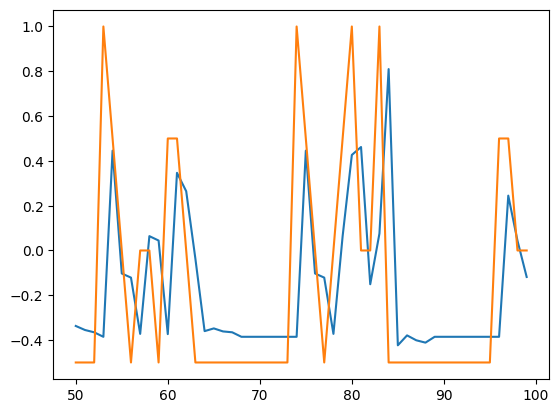

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [16]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

13/13 [==============================] - 0s 1ms/step


,Val Predictions,Actuals
0,-0.815151,-1.0
1,-0.815151,-1.0
2,-0.815151,-1.0
3,-0.815151,-1.0
4,-0.815151,-1.0
...,...,...
395,-0.836066,-1.0
396,-0.815151,-1.0
397,-0.815151,-1.0
398,-0.815151,-1.0


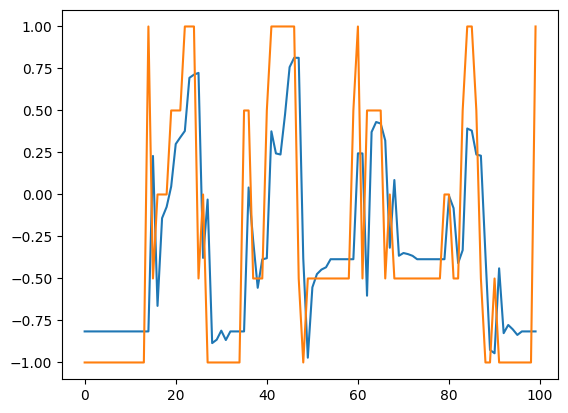

In [17]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [18]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,-0.815151,-1.0
1,-0.815151,0.5
2,0.041679,-0.5
3,-0.618008,-0.5
4,-0.455361,-0.5
...,...,...
190,-0.775682,0.0
191,-0.027712,-1.0
192,-0.889973,-1.0
193,-0.753030,-1.0


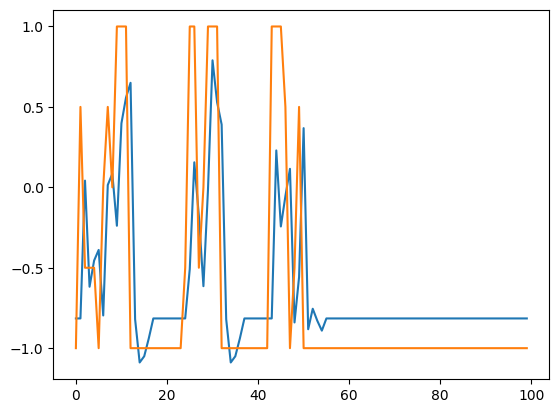

In [19]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [20]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

7/7 [==============================] - 0s 2ms/step


(     Predictions  Actuals
 0      -0.815151     -1.0
 1      -0.815151      0.5
 2       0.041679     -0.5
 3      -0.618008     -0.5
 4      -0.455361     -0.5
 ..           ...      ...
 190    -0.775682      0.0
 191    -0.027712     -1.0
 192    -0.889973     -1.0
 193    -0.753030     -1.0
 194    -0.802313     -1.0
 
 [195 rows x 2 columns],
 0.2508752583337864)

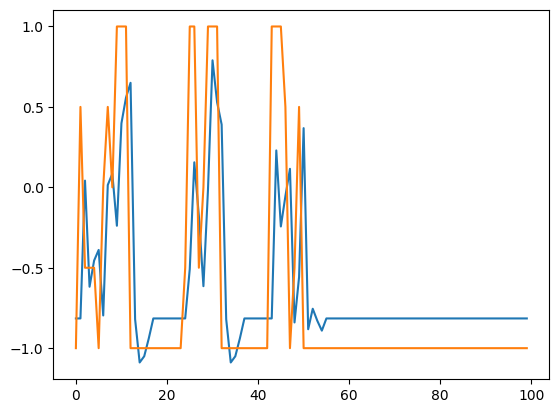

In [21]:
plot_predictions1(model1, X_test1, y_test1)